# Asteroid Light Curves Examples - Part 2

This notebook uses the same asteroid light curve data as part 1 but looks at several unsupervised techniques.

## Objectives

- Understand several techniques that might be available when you have little or no labeled data.

In [1]:
# Path to the ALCDEF_ALL dataset downloaded from http://alcdef.org
# Download the full archive as a .zip file. Extract its contents to this
# directory. It should be ~14K .txt files.
data_dir = 'data/ALCDEF_ALL'

# Discard any light curves with fewer than this many samples
min_samples = 100

# Resample light curves to common number of samples
nb_samples = 100

# Imports

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from glob import glob
from scipy.signal import resample
from collections import Counter

import random

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Reshape
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Input

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import pandas as pd
import seaborn as sns

from ml4ssa_utils import visualize_embedding, load_alcdef_data, plot_alcdef_examples, normalize_features, plot_confusion_matrix

# Load Dataset

Load data from Astroid Lightcurve Photometry Database (http://alcdef.org/)

In [9]:
data = load_alcdef_data(
    data_dir=data_dir,
    min_samples=min_samples,
    resample_to=nb_samples,
    reduce_to_top=60 # keeping the 60 most common object types
)

# Visualize Raw Features

In [10]:
X = np.stack([item['DATA_RESAMPLED'][:,1] for item in data])
X.shape
names = list(set([item['OBJECTNAME'] for item in data]))
y = np.array([ names.index(item['OBJECTNAME']) for item in data ])

C:\Users\jpula\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


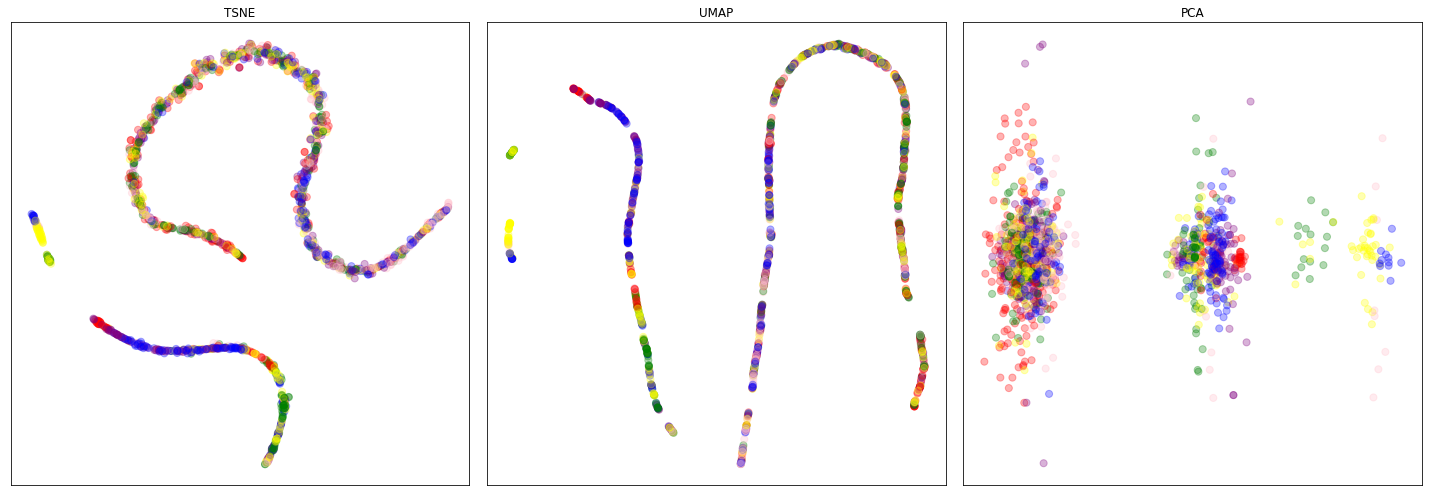

In [11]:
visualize_embedding(X, y)

# Self-Supervised Techniques

We often have access to features but few or no corresponding targets. In these cases, one powerful technique is called self-supervision. The setup usually involves taking (or sometimes making) features that you do not particularly care about and treating them as targets. The hope is that in learning to predict these targets you will have forced the network to learn something genuinly useful about the data.

For example, an __auto-encoder__ is a neural network whose goal is to cover its input. To make that an interesting problem, the network topology is designed to have a low-dimensional choke point. By the nature of having this choke point, a trained auto-encoder must have learned an apposimate low-dimensional representation of your original data. 

In [54]:
nb_classes = len(names)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=8, kernel_size=5, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(GlobalAveragePooling1D())
#model.add(Dense(units=32, activation='relu'))
#model.add(Dense(units=32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dense(units=nb_samples, activation='sigmoid'))
model.add(Reshape(input_shape=(nb_samples,), target_shape=(nb_samples,1)))
model.add(Conv1D(filters=1, kernel_size=5, activation='linear', padding='same'))
model.add(Flatten())

model.compile(
    loss='mse',
    optimizer='adam'
)

# keras is complaining that I need to evaluate the model before printing a summary
model.predict(np.zeros((16,100,1)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 96, 64)            384       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 48, 64)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 44, 32)            10272     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 22, 32)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 18, 8)             1288      
_________________________________________________________________
global_average_pooling1d_12  (None, 8)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               900       
__________

In [55]:
# Prepare data to pass to model
repeats = 1
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.
train_features = normalize_features(X.repeat(repeats, axis=0))
train_targets = np.copy(train_features)

# The convolutional layers will expect a "channels" dimension at the end.
train_features = np.expand_dims(train_features, axis=-1)

model.fit(
    train_features, train_targets,
    epochs=10,
    batch_size=16,
    verbose=1
)

Epoch 1/10
1609/1609 [==============================] - 29s 18ms/step - loss: 1.2821
Epoch 2/10
1609/1609 [==============================] - 29s 18ms/step - loss: 0.4281
Epoch 3/10
1609/1609 [==============================] - 28s 17ms/step - loss: 0.3298
Epoch 4/10
1609/1609 [==============================] - 27s 17ms/step - loss: 0.2671
Epoch 5/10
1609/1609 [==============================] - 29s 18ms/step - loss: 0.2135
Epoch 6/10
1609/1609 [==============================] - 29s 18ms/step - loss: 0.1690
Epoch 7/10
1609/1609 [==============================] - 29s 18ms/step - loss: 0.1360
Epoch 8/10
1609/1609 [==============================] - 28s 18ms/step - loss: 0.1117
Epoch 9/10
1609/1609 [==============================] - 30s 18ms/step - loss: 0.0938
Epoch 10/10
1609/1609 [==============================] - 29s 18ms/step - loss: 0.0794


In [59]:
# Here we extract the intermediate features/activations from the layer named penultimate
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-5].output)
X_embedding = intermediate_layer_model.predict(train_features[:len(X)])

C:\Users\jpula\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


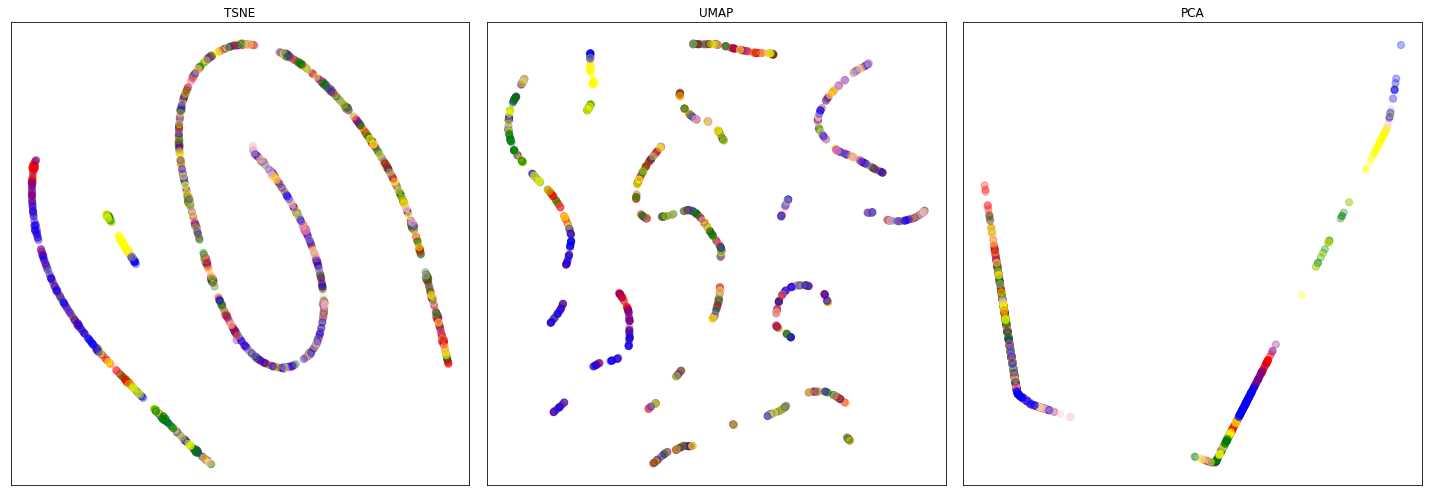

In [62]:
visualize_embedding(X_embedding, y)